# Model-Assisted Labeling (MAL) Workflow with DeepLab & CVAT (Later ML Paint for comparison)

This notebook provides an end-to-end MAL pipeline:

1. **Tile Split**: Break large GeoTIFF images into 512×512 tiles
2. **Prediction**: Generate masks using trained DeepLab model
3. **Visualization**: Preview predictions before CVAT annotation
4. **CVAT Refinement**: Manual annotation/correction (in web UI, not here)
5. **Reconstruction**: Stitch corrected masks back into full GeoTIFF

**Workflow**: Phase 1 → Phase 2 → Phase 3 → (CVAT in browser) → Phase 5

# Installing CVAT on Windows

## Step 1: Install Git for Windows

1. Download Git for Windows from [https://gitforwindows.org/](https://gitforwindows.org/).
2. Install Git, keeping all options as default.
3. Open the command prompt (`cmd`) and type the following command to check the Git version:
    ```bash
    git --version
    ```

## Step 2: Install Docker Desktop for Windows

1. Download [Docker Desktop for Windows](https://desktop.docker.com/win/main/amd64/Docker%20Desktop%20Installer.exe).
2. Double-click the Docker for Windows Installer to run the installer.
3. Follow the instructions for installation, and reboot the system after installation is complete.
4. Open the command prompt and check the Docker version:
    ```bash
    docker --version
    ```
5. Check the Docker Compose version:
    ```bash
    docker compose version
    ```

## Step 3: Install Google Chrome

1. Download and install [Google Chrome](https://www.google.com/chrome/), as it is the only browser supported by CVAT.

## Step 4: Clone CVAT Source Code

1. Clone CVAT source code from the [GitHub repository](https://github.com/opencv/cvat):
    ```bash
    git clone https://github.com/opencv/cvat
    cd cvat
    ```
2. Alternatively, check [alternatives](https://opencv.github.io/cvat/docs/administration/basics/installation/#how-to-get-cvat-source-code) for downloading specific release versions.

## Step 5: Run Docker Containers for CVAT

1. Run the following command to start Docker containers. This will download the latest CVAT release and other required images:
    ```bash
    docker compose up -d
    ```
2. Optionally, specify the CVAT version using the CVAT_VERSION environment variable:
    ```bash
    CVAT_VERSION=dev docker compose up -d
    ```
3. Check the status of the containers:
    ```bash
    docker ps
    ```
4. Wait until the CVAT server is up and running:
    ```bash
    docker logs cvat_server -f
    ```
5. Run the CVAT server:
    ```bash
    docker exec -it cvat_server bash
    ```
6. For the first-time setup, create a superuser account:
    ```bash
    python3 manage.py createsuperuser
    ```
    Choose a username and password for the admin account.

## Step 6: Access CVAT in Google Chrome

1. Open Google Chrome and go to `localhost:8080`.
2. Log in with the superuser credentials created earlier.
3. You should now be able to create a new annotation task.

## Workflow
To stop and remove the container, simply type, 
```bash
docker compose down
```
And to start cvat again, simply type 
```bash
docker compose up -d
```
Make sure you're in the correct directory

In [196]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import shutil
from typing import Dict, List

# Add project to path
sys.path.insert(0, '../../')
from models import DeepLab

# Check GPU
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}\n")

# Configuration
CLASS_NAMES = ['background', 'building', 'woodland', 'water', 'road']
NUM_CLASSES = len(CLASS_NAMES)
TILE_SIZE = 512

# Define workspace directories
WORKSPACE_DIR = Path("mal_workspace")
TILES_DIR = WORKSPACE_DIR / "01_tiles"
PREDICTIONS_DIR = WORKSPACE_DIR / "02_predictions"
CORRECTED_MASKS_DIR = WORKSPACE_DIR / "03_corrected_masks"
RECONSTRUCTED_DIR = WORKSPACE_DIR / "04_reconstructed"

print(f"✓ Setup complete | Device: {device}")

PyTorch: 2.4.1+cu124
CUDA available: True
Device: NVIDIA GeForce RTX 4060
Memory: 8.0 GB
Using device: cuda

✓ Setup complete | Device: cuda


In [197]:
# ===== UPDATE THESE PATHS =====
INPUT_GEOTIFF = "cvat_test/images/M-33-7-A-d-2-3.tif"  # Change this path as needed
CHECKPOINT_PATH = "experiments/Deeplab_Landcover_Edited/best_model.pth"  # Change this to your model
# ==============================

# Verify files exist
if not Path(INPUT_GEOTIFF).exists():
    print(f"⚠️  WARNING: {INPUT_GEOTIFF} not found!")
else:
    print(f"✓ Input GeoTIFF: {INPUT_GEOTIFF}")

if not Path(CHECKPOINT_PATH).exists():
    print(f"⚠️  WARNING: {CHECKPOINT_PATH} not found!")
else:
    print(f"✓ Checkpoint: {CHECKPOINT_PATH}")

print(f"\nWorkspace: {WORKSPACE_DIR}")
print(f"Classes: {CLASS_NAMES}")

✓ Input GeoTIFF: cvat_test/images/M-33-7-A-d-2-3.tif
✓ Checkpoint: experiments/Deeplab_Landcover_Edited/best_model.pth

Workspace: mal_workspace
Classes: ['background', 'building', 'woodland', 'water', 'road']


In [198]:
def tile_geotiff(input_path: str, output_dir: str, tile_size: int = 512, overlap: int = 0) -> Dict:
    """
    Break a large GeoTIFF into non-overlapping or overlapping tiles.
    
    Args:
        input_path: Path to input GeoTIFF
        output_dir: Directory to save tiles
        tile_size: Tile size (default 512)
        overlap: Overlap in pixels between tiles (default 0)
    
    Returns:
        Metadata dict with tile info and original shape
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Load image
    img = Image.open(input_path)
    img_array = np.array(img)
    height, width = img_array.shape[:2]
    
    print(f"Tiling {Path(input_path).name}")
    print(f"  Original shape: {img_array.shape}")
    print(f"  Tile size: {tile_size}×{tile_size}, Overlap: {overlap}px")
    
    tiles_metadata = []
    stride = tile_size - overlap
    
    # Extract tiles
    for y in range(0, height - tile_size + 1, stride):
        for x in range(0, width - tile_size + 1, stride):
            tile = img_array[y:y+tile_size, x:x+tile_size]
            
            if tile.shape[0] != tile_size or tile.shape[1] != tile_size:
                continue
            
            tile_name = f"tile_{y:05d}_{x:05d}"
            tile_path = Path(output_dir) / f"{tile_name}.png"
            
            Image.fromarray(tile.astype(np.uint8)).save(tile_path)
            
            tiles_metadata.append({
                "tile_id": tile_name,
                "filename": f"{tile_name}.png",
                "original_x": int(x),
                "original_y": int(y),
                "width": tile_size,
                "height": tile_size
            })
    
    metadata = {
        "original_shape": list(img_array.shape),
        "tile_size": tile_size,
        "tile_count": len(tiles_metadata),
        "tiles": tiles_metadata
    }
    
    print(f"✓ Created {len(tiles_metadata)} tiles\n")
    return metadata

print("✓ Tiling function loaded")

✓ Tiling function loaded


In [199]:
def load_model(checkpoint_path: str) -> DeepLab:
    """Load trained DeepLab model."""
    model = DeepLab(
        num_classes=NUM_CLASSES,
        input_image_size=TILE_SIZE,
        backbone='resnet50',
        output_stride=4
    ).to(device)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    if isinstance(checkpoint, dict) and 'model' in checkpoint:
        model.load_state_dict(checkpoint['model'])
    else:
        model.load_state_dict(checkpoint)
    
    model.eval()
    
    # Ensure all dropout and batch norm layers are in eval mode
    for module in model.modules():
        if isinstance(module, (nn.Dropout, nn.BatchNorm2d)):
            module.eval()
    
    print(f"✓ Model loaded from {Path(checkpoint_path).name}\n")
    return model


def normalize_image(image: np.ndarray) -> torch.Tensor:
    """Normalize image to [-2, 2] range using ImageNet stats."""
    image = image.astype(np.float32) / 255.0
    image = torch.from_numpy(image).permute(2, 0, 1)
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = (image - mean) / std
    
    return image


def predict_single_tile(model: DeepLab, image_path: str, debug: bool = False) -> np.ndarray:
    """Generate prediction mask for one tile."""
    image = np.array(Image.open(image_path).convert('RGB'))
    image_tensor = normalize_image(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        
        if debug:
            print(f"Output shape: {output.shape}")
            print(f"Output min/max: {output.min():.4f} / {output.max():.4f}")
            print(f"Class logits sample (center pixel): {output[0, :, 256, 256]}")
        
        mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        
        if debug:
            print(f"Mask unique classes: {np.unique(mask)}\n")
    
    return mask.astype(np.uint8)


def generate_all_predictions(model: DeepLab, tiles_dir: str, output_dir: str) -> List[str]:
    """Generate predictions for all tiles in a directory."""
    os.makedirs(output_dir, exist_ok=True)
    
    tile_files = sorted([f for f in os.listdir(tiles_dir) if f.endswith('.png')])
    print(f"Generating predictions for {len(tile_files)} tiles...")
    
    # Test first tile with debug info
    if tile_files:
        first_tile = Path(tiles_dir) / tile_files[0]
        print(f"\n🔍 Testing first tile: {tile_files[0]}")
        test_mask = predict_single_tile(model, str(first_tile), debug=True)
    
    prediction_paths = []
    for tile_file in tqdm(tile_files, desc="Predicting"):
        tile_path = Path(tiles_dir) / tile_file
        pred_mask = predict_single_tile(model, str(tile_path))
        
        pred_name = tile_file.replace('.png', '_pred.png')
        pred_path = Path(output_dir) / pred_name
        
        Image.fromarray(pred_mask).save(pred_path)
        prediction_paths.append(pred_path)
    
    print(f"✓ Generated {len(prediction_paths)} predictions\n")
    return prediction_paths

print("✓ Inference functions loaded")

✓ Inference functions loaded


In [200]:
def visualize_predictions(tiles_dir: str, predictions_dir: str, num_samples: int = 4):
    """
    Display sample tiles with predictions.
    
    Shows: Original Image | Predicted Mask | Overlay
    """
    tile_files = sorted([f for f in os.listdir(tiles_dir) if f.endswith('.png')])
    indices = np.random.choice(len(tile_files), min(num_samples, len(tile_files)), replace=False)
    
    class_colors = {
        0: [0.0, 0.0, 0.0],       # background - black
        1: [1.0, 0.0, 0.0],       # building - red
        2: [0.0, 0.5, 0.0],       # woodland - green
        3: [0.0, 0.0, 1.0],       # water - blue
        4: [1.0, 1.0, 0.0],       # road - yellow
    }
    
    fig, axes = plt.subplots(len(indices), 3, figsize=(14, 4*len(indices)))
    fig.suptitle('Sample Predictions (Image | Mask | Overlay)', fontsize=14, fontweight='bold')
    
    for row, idx in enumerate(indices):
        tile_file = tile_files[idx]
        tile_path = Path(tiles_dir) / tile_file
        pred_file = tile_file.replace('.png', '_pred.png')
        pred_path = Path(predictions_dir) / pred_file
        
        image = np.array(Image.open(tile_path))
        pred_mask = np.array(Image.open(pred_path))
        
        # Column 1: Image
        axes[row, 0].imshow(image)
        axes[row, 0].set_title(f'Image', fontsize=10)
        axes[row, 0].axis('off')
        
        # Column 2: Mask
        axes[row, 1].imshow(pred_mask, cmap='tab10', vmin=0, vmax=4)
        axes[row, 1].set_title(f'Mask (classes: {np.unique(pred_mask)})', fontsize=10)
        axes[row, 1].axis('off')
        
        # Column 3: Overlay
        mask_rgb = np.zeros((*pred_mask.shape, 3))
        for class_id, color in class_colors.items():
            mask_rgb[pred_mask == class_id] = color
        overlay = 0.65 * (image / 255.0) + 0.35 * mask_rgb
        axes[row, 2].imshow(overlay)
        axes[row, 2].set_title('Overlay', fontsize=10)
        axes[row, 2].axis('off')
    
    plt.tight_layout()
    return fig


In [201]:
def extract_cvat_labelmap(labelmap_txt_path: str) -> Dict[int, tuple]:
    """
    Extract color mapping from labelmap.txt file.
    
    Args:
        labelmap_txt_path: Path to labelmap.txt
    
    Returns:
        Dict mapping class_id to RGB tuple: {0: (0, 0, 0), 1: (250, 50, 83), ...}
    """
    from pathlib import Path
    
    labelmap_path = Path(labelmap_txt_path)
    
    if not labelmap_path.exists():
        print(f"⚠️  Warning: {labelmap_path} not found")
        return None
    
    try:
        with open(labelmap_path, 'r') as f:
            labelmap_content = f.read()
        
        color_map = {}
        class_names = ['background', 'building', 'road', 'water', 'woodland']
        
        for line in labelmap_content.strip().split('\n'):
            if not line or line.startswith('#'):
                continue
            
            # Parse: "label:color_rgb:parts:actions"
            parts = line.split(':')
            if len(parts) < 2:
                continue
            
            label = parts[0].strip()
            color_str = parts[1].strip()
            
            # Parse color: "R,G,B"
            try:
                r, g, b = map(int, color_str.split(','))
                if label in class_names:
                    class_id = class_names.index(label)
                    color_map[class_id] = (r, g, b)
                    print(f"  Loaded: class {class_id} ({label}) → RGB({r}, {g}, {b})")
            except ValueError:
                continue
        
        if not color_map:
            print(f"⚠️  Could not parse any colors from {labelmap_path}")
            return None
        
        return color_map
    except Exception as e:
        print(f"⚠️  Error reading labelmap: {e}")
        return None

print("✓ Helper functions loaded")

✓ Helper functions loaded


In [202]:
def reconstruct_geotiff(tiles_metadata: Dict, source_masks_dir: str, output_path: str, mask_type: str = "masks", cvat_labelmap_zip: str = None):
    """
    Stitch tile masks back into a single GeoTIFF.
    Handles both raw class indices and CVAT RGB-encoded masks.
    
    Args:
        tiles_metadata: Output from tile_geotiff() function
        source_masks_dir: Directory containing masks
        output_path: Path to save final GeoTIFF
        mask_type: Description for logging
        cvat_labelmap_zip: Path to CVAT exported ZIP to extract labelmap colors from
    """
    original_shape = tiles_metadata['original_shape']
    tile_size = tiles_metadata['tile_size']
    
    output_mask = np.zeros(original_shape[:2], dtype=np.uint8)
    
    print(f"Reconstructing {mask_type}...")
    print(f"  Source: {source_masks_dir}")
    print(f"  Output shape: {output_mask.shape}")
    print(f"  Processing {len(tiles_metadata['tiles'])} tiles...")
    
    # Try to load CVAT labelmap colors from ZIP
    cvat_class_colors_rgb = None
    if cvat_labelmap_zip:
        print(f"\n  Loading colors from CVAT export: {cvat_labelmap_zip}")
        cvat_class_colors_rgb = extract_cvat_labelmap(cvat_labelmap_zip)
        print()
    
    # Fallback to default if not provided or extraction failed
    if cvat_class_colors_rgb is None:
        print(f"  Using default CVAT colors")
        cvat_class_colors_rgb = {
            0: (0, 0, 0),           # background - black
            1: (250, 50, 83),       # building - coral/red
            2: (255, 204, 51),      # road - gold
            3: (52, 209, 183),      # water - teal
            4: (36, 179, 83),       # woodland - green
        }
    
    # Create reverse mapping: RGB tuple -> class_id
    color_to_class = {}
    for class_id, rgb in cvat_class_colors_rgb.items():
        color_to_class[rgb] = class_id
    
    found_count = 0
    for tile_info in tqdm(tiles_metadata['tiles'], desc="Stitching"):
        tile_id = tile_info['tile_id']
        x = tile_info['original_x']
        y = tile_info['original_y']
        
        # Try multiple filename formats
        candidates = [
            f"{tile_id}_pred.png",
            f"{tile_id}.png",
            Path(source_masks_dir) / f"{tile_id}_pred.png",
            Path(source_masks_dir) / f"{tile_id}.png"
        ]
        
        mask_path = None
        for candidate in candidates:
            if isinstance(candidate, str):
                candidate = Path(source_masks_dir) / candidate
            if candidate.exists():
                mask_path = candidate
                break
        
        if mask_path is None:
            continue
        
        pil_image = Image.open(mask_path)
        img_array = np.array(pil_image)
        
        # Handle different formats
        if img_array.ndim == 3 and img_array.shape[2] == 3:
            # RGB image from CVAT: map colors back to class indices
            mask = np.zeros(img_array.shape[:2], dtype=np.uint8)
            for y_px in range(img_array.shape[0]):
                for x_px in range(img_array.shape[1]):
                    rgb = tuple(img_array[y_px, x_px])
                    # Direct mapping to CVAT's color scheme
                    if rgb in color_to_class:
                        mask[y_px, x_px] = color_to_class[rgb]
                    else:
                        # Find nearest color using Euclidean distance
                        min_dist = float('inf')
                        best_class = 0
                        for class_id, class_rgb in cvat_class_colors_rgb.items():
                            dist = sum((rgb[i] - class_rgb[i])**2 for i in range(3))
                            if dist < min_dist:
                                min_dist = dist
                                best_class = class_id
                        mask[y_px, x_px] = best_class
        else:
            # Raw grayscale: use directly
            mask = img_array if img_array.ndim == 2 else img_array[:, :, 0]
        
        output_mask[y:y+tile_size, x:x+tile_size] = mask
        found_count += 1
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    Image.fromarray(output_mask).save(output_path)
    
    print(f"✓ Reconstructed {mask_type}")
    print(f"  Output: {output_path}")
    print(f"  Tiles found: {found_count}/{len(tiles_metadata['tiles'])}")
    print(f"  Classes: {np.unique(output_mask)}\n")

In [203]:
def create_cvat_segmentation_mask_export(
    predictions_dir: str,
    output_zip: str,
    class_names: List[str],
    class_colors: Dict[int, tuple] = None
):
    """
    Create a CVAT-compatible Segmentation Mask ZIP file for importing predictions.

    Args:
        predictions_dir: Directory with prediction masks (*_pred.png files)
        output_zip: Path to save the ZIP file (e.g., "mal_workspace/cvat_export.zip")
        class_names: List of class names (e.g., ['background', 'building', 'woodland', 'water', 'road'])
        class_colors: Dict mapping class_id to RGB tuple for labelmap.txt
                     If None, uses default Pascal VOC colors

    Creates this ZIP structure (Required by CVAT. More details check documentation https://docs.cvat.ai/docs/dataset_management/formats/):
        archive.zip/
        ├── labelmap.txt
        ├── ImageSets/Segmentation/default.txt
        ├── SegmentationClass/
        │   ├── tile_00000_00000.png
        │   ├── tile_00000_00512.png
        │   └── ...
        └── SegmentationObject/
            ├── tile_00000_00000.png
            ├── tile_00000_00512.png
            └── ...
    """
    import zipfile
    import tempfile

    # Default Pascal VOC colors if not provided
    if class_colors is None:
        class_colors = {
            0: (0, 0, 0),           # background - black
            1: (128, 0, 0),         # building - maroon
            2: (0, 128, 0),         # woodland - dark green
            3: (0, 0, 128),         # water - navy blue
            4: (128, 128, 0),       # road - olive
        }

    # Create temporary directory for ZIP contents
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_path = Path(temp_dir)

        # Create directory structure
        segmentation_class_dir = temp_path / "SegmentationClass"
        segmentation_object_dir = temp_path / "SegmentationObject"
        imageset_dir = temp_path / "ImageSets" / "Segmentation"

        segmentation_class_dir.mkdir(parents=True, exist_ok=True)
        segmentation_object_dir.mkdir(parents=True, exist_ok=True)
        imageset_dir.mkdir(parents=True, exist_ok=True)

        # ===== CREATE labelmap.txt =====
        labelmap_path = temp_path / "labelmap.txt"
        with open(labelmap_path, 'w') as f:
            for class_id, class_name in enumerate(class_names):
                color = class_colors.get(class_id, (0, 0, 0))
                f.write(f"{class_name}:{color[0]},{color[1]},{color[2]}::\n")

        print(f"Created labelmap.txt with {len(class_names)} classes")

        # ===== GET PREDICTION FILES =====
        pred_files = sorted([f for f in os.listdir(predictions_dir) if f.endswith('.png')])
        image_names = []

        print(f"Processing {len(pred_files)} prediction masks...")

        # ===== COPY MASKS TO BOTH DIRECTORIES =====
        for pred_file in tqdm(pred_files, desc="Copying masks"):
            pred_path = Path(predictions_dir) / pred_file

            # Extract base name (remove '_pred.png' or '.png')
            if pred_file.endswith('_pred.png'):
                base_name = pred_file.replace('_pred.png', '')
            else:
                base_name = pred_file.replace('.png', '')
            
            image_names.append(base_name)

            # Load mask
            mask = np.array(Image.open(pred_path))
            
            # For semantic segmentation, both directories get the same mask
            # (SegmentationClass = class per pixel, SegmentationObject = same for semantic)
            Image.fromarray(mask).save(segmentation_class_dir / f"{base_name}.png")
            Image.fromarray(mask).save(segmentation_object_dir / f"{base_name}.png")

        # ===== CREATE ImageSets/Segmentation/default.txt =====
        default_txt = imageset_dir / "default.txt"
        with open(default_txt, 'w') as f:
            for name in image_names:
                f.write(name + '\n')

        print(f"Created ImageSets/Segmentation/default.txt with {len(image_names)} entries")

        # ===== CREATE ZIP ARCHIVE =====
        os.makedirs(os.path.dirname(output_zip), exist_ok=True)
        
        with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Add all files from temp directory to ZIP
            for root, dirs, files in os.walk(temp_path):
                for file in files:
                    file_path = Path(root) / file
                    # Get relative path from temp_path for ZIP archive
                    arcname = file_path.relative_to(temp_path)
                    zipf.write(file_path, arcname)

        # Print results
        zip_size_mb = Path(output_zip).stat().st_size / (1024**2)
        print(f"\n✓ CVAT Segmentation Mask export created successfully!")
        print(f"  Output ZIP: {output_zip}")
        print(f"  Size: {zip_size_mb:.1f} MB")
        print(f"  Classes: {len(class_names)}")
        print(f"  Masks: {len(image_names)}")

print("✓ CVAT export function loaded")

✓ CVAT export function loaded


In [204]:
print("=" * 60)
print("PHASE 1: TILE SPLITTING")
print("=" * 60)

# Create tiles
tiles_metadata = tile_geotiff(
    input_path=INPUT_GEOTIFF,
    output_dir=str(TILES_DIR),
    tile_size=TILE_SIZE,
    overlap=0  # Change to 64 for 64px overlap if desired. We using 0 overlapping for now
)

# Save metadata for later use
metadata_path = WORKSPACE_DIR / "tiles_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(tiles_metadata, f, indent=2)

print(f"Metadata saved: {metadata_path}")


PHASE 1: TILE SPLITTING
Tiling M-33-7-A-d-2-3.tif
  Original shape: (9711, 9081, 3)
  Tile size: 512×512, Overlap: 0px
✓ Created 306 tiles

Metadata saved: mal_workspace\tiles_metadata.json


In [205]:
print("=" * 60)
print("PHASE 2: GENERATE PREDICTIONS")
print("=" * 60)

# Load model
model = load_model(CHECKPOINT_PATH)

# Generate predictions
prediction_paths = generate_all_predictions(
    model=model,
    tiles_dir=str(TILES_DIR),
    output_dir=str(PREDICTIONS_DIR)
)

PHASE 2: GENERATE PREDICTIONS


C:\Users\adytc\AppData\Local\Temp\ipykernel_38592\2567624637.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

✓ Model loaded from best_model.pth

Generating predictions for 306 tiles...

🔍 Testing first tile: tile_00000_00000.png
Output shape: torch.Size([1, 5, 512, 512])
Output min/max: -1.9766 / 2.0475
Class logits sample (center pixel): tensor([ 0.0513,  1.9003,  1.5035, -1.8069, -0.5330], device='cuda:0')
Mask unique classes: [0 1 2]



Predicting: 100%|██████████| 306/306 [00:37<00:00,  8.05it/s]

✓ Generated 306 predictions



In [206]:
# Create CVAT-compatible export
create_cvat_segmentation_mask_export(
    predictions_dir=str(PREDICTIONS_DIR),
    output_zip="mal_workspace/cvat_predictions_export.zip",
    class_names=CLASS_NAMES,
    class_colors={
        0: (0, 0, 0),         # background - black
        1: (128, 0, 0),       # building - maroon
        2: (0, 128, 0),       # woodland - dark green
        3: (0, 0, 128),       # water - navy blue
        4: (128, 128, 0),     # road - olive
    }
)

Created labelmap.txt with 5 classes
Processing 306 prediction masks...


Copying masks: 100%|██████████| 306/306 [00:02<00:00, 106.00it/s]


Created ImageSets/Segmentation/default.txt with 306 entries

✓ CVAT Segmentation Mask export created successfully!
  Output ZIP: mal_workspace/cvat_predictions_export.zip
  Size: 1.9 MB
  Classes: 5
  Masks: 306


PHASE 3: VISUALIZE PREDICTIONS


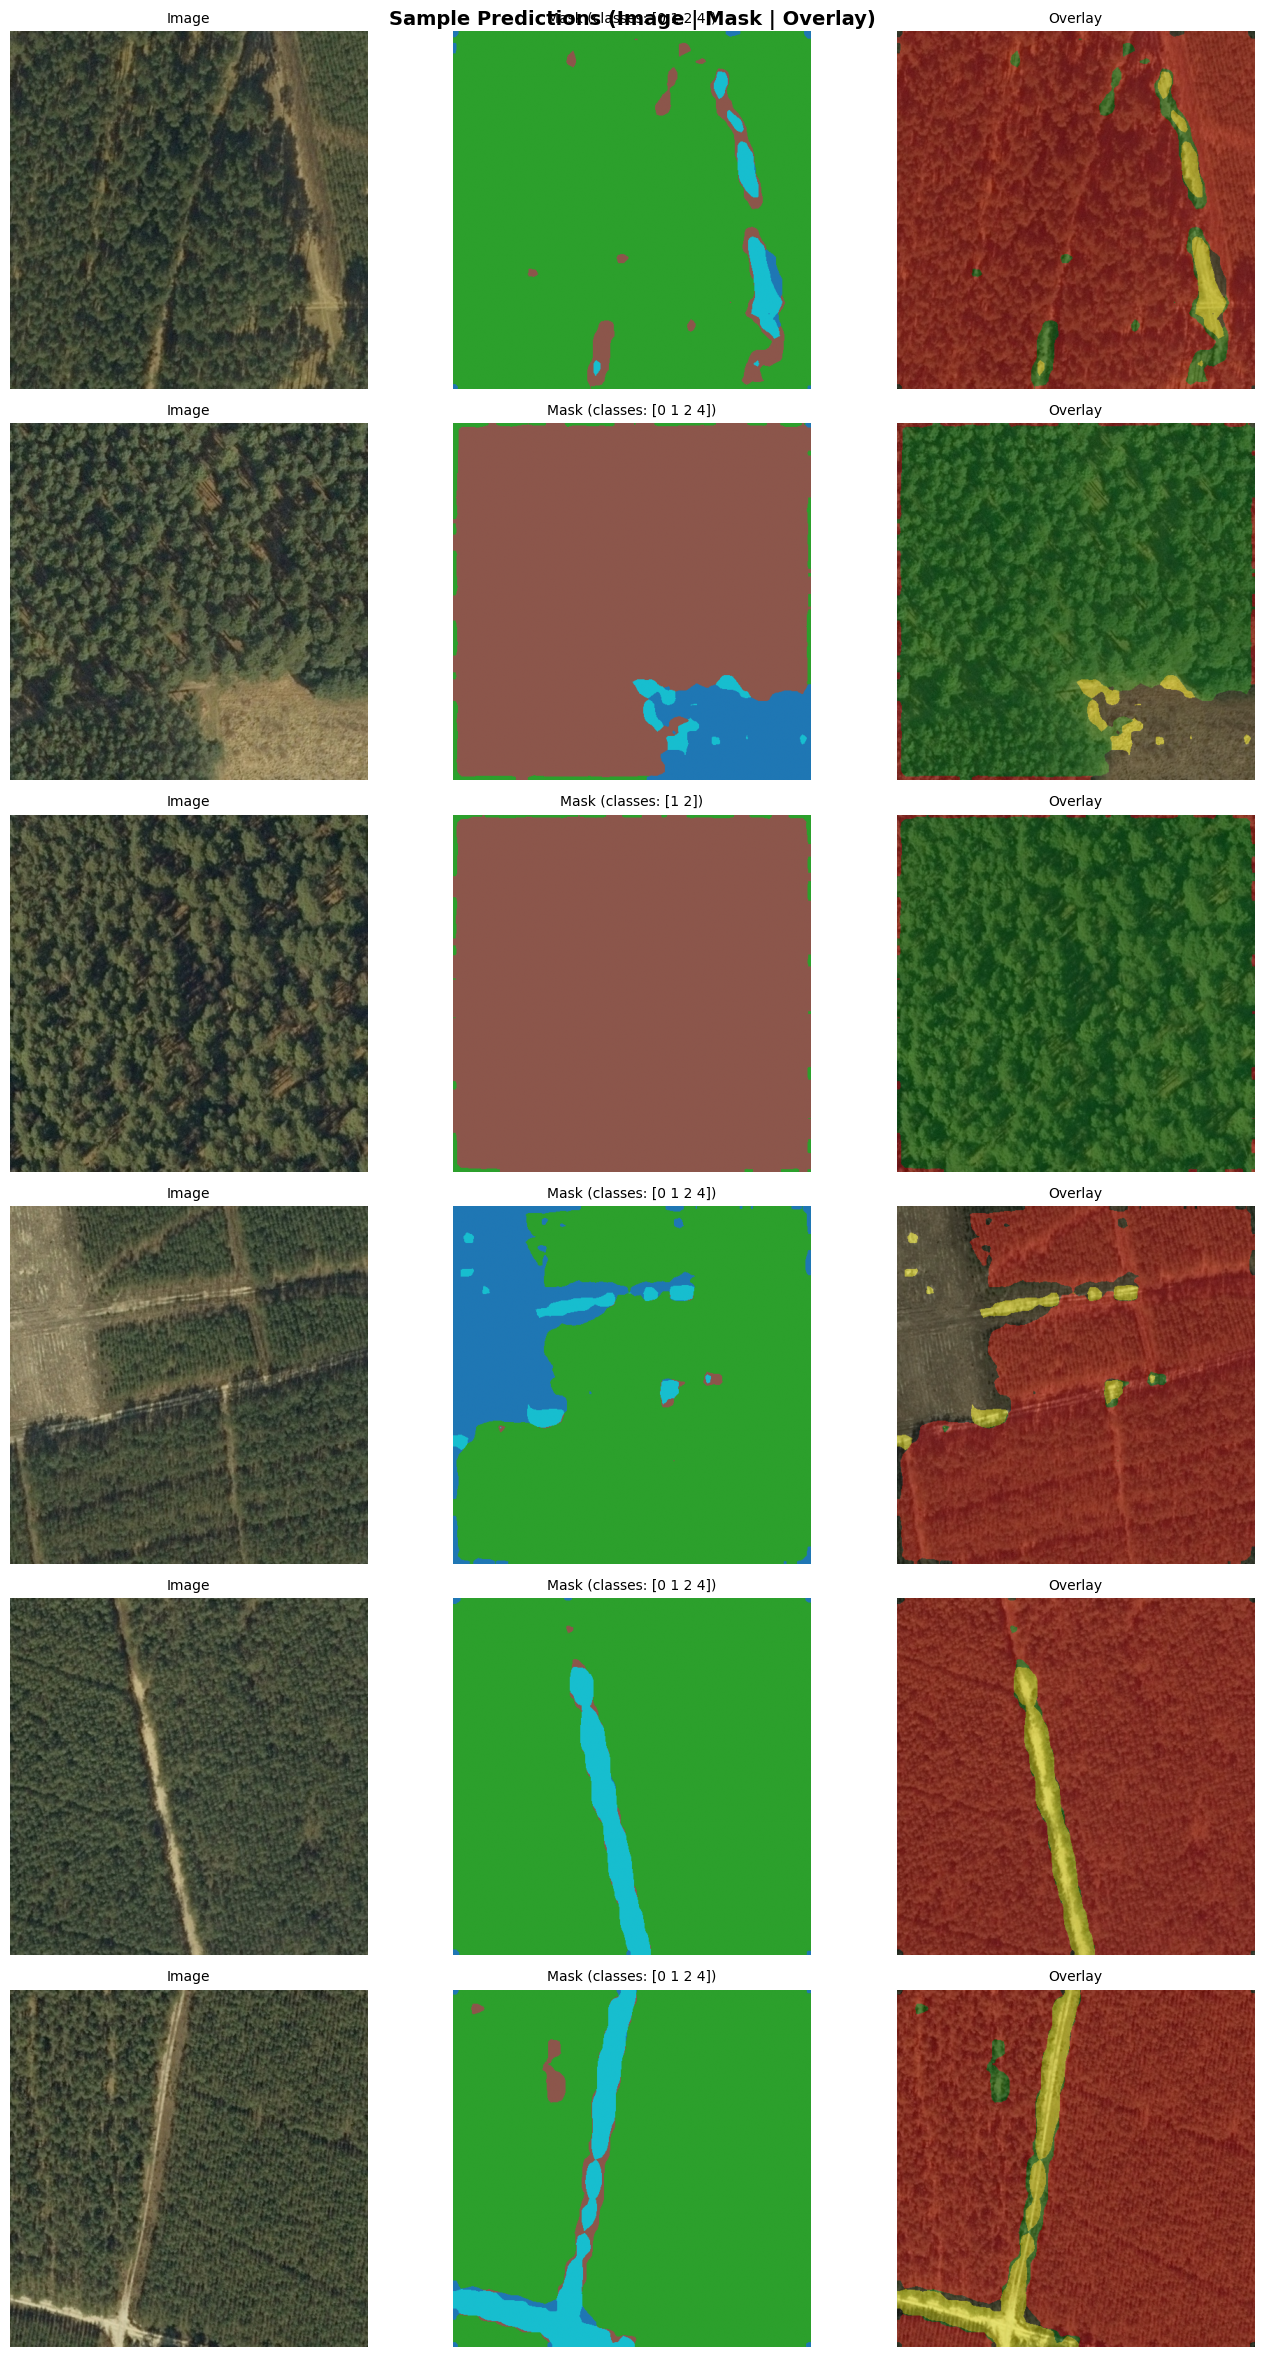

Preview saved: mal_workspace\predictions_preview.png


In [207]:
print("=" * 60)
print("PHASE 3: VISUALIZE PREDICTIONS")
print("=" * 60)

fig = visualize_predictions(
    tiles_dir=str(TILES_DIR),
    predictions_dir=str(PREDICTIONS_DIR),
    num_samples=6  # Change to see more/fewer samples
)

plt.savefig(WORKSPACE_DIR / "predictions_preview.png", dpi=100, bbox_inches='tight')
plt.show()

print(f"Preview saved: {WORKSPACE_DIR / 'predictions_preview.png'}")

## Phase 4: Manual Annotation in CVAT

**Important**: This step happens in the CVAT web UI (`http://localhost:8080`), not in this notebook.

### Step 1: Prepare Files
- Tiles are ready in: `mal_workspace/01_tiles/`
- Predictions are ready in: `mal_workspace/02_predictions/`

### Step 2: Create CVAT Project
1. Open http://localhost:8080 in your browser
2. Click "Create a new project"
3. Name it however you want
4. Add labels at constructor (Important for CVAT to recognize the annotations):
   - `background` (class 0)
   - `building` (class 1)
   - `woodland` (class 2)
   - `water` (class 3)
   - `road` (class 4)
5. Submit and open

### Step 3: Create CVAT Task
1. Create a task
2. Name however you want
3. Upload the images you want to annotate. It should be `mal_workspace/01_tiles/`
4. Submit and open

### Step 4: Import Initial Predictions
1. Click Menu → Upload annotations
2. Choose Segmentation mask 1.1
3. Upload the ZIP file `mal_workspace\cvat_predictions_export.zip`

### Step 5: Refine Annotations
1. For each tile:
   - Use **Brush** tool to add pixels
   - Use **Eraser** to remove pixels
2. Save changes frequently
(There should be a better workflow. Investigating)

### Step 6: Export Corrected Masks
1. Click Menu → Export task dataset
2. Select "Segmentation mask 1.1" format
3. Download ZIP file
4. Extract SegmentationClass folder to: `mal_workspace/03_corrected_masks/`

Once done, proceed to Phase 5 below.

In [208]:
print("=" * 60)
print("PHASE 5: RECONSTRUCT GEOTIFF")
print("=" * 60)

# Load metadata
metadata_path = WORKSPACE_DIR / "tiles_metadata.json"
with open(metadata_path, 'r') as f:
    tiles_metadata = json.load(f)

# Reconstruct predicted masks from 02_predictions
pred_output = RECONSTRUCTED_DIR / "predictions_reconstructed.tif"
reconstruct_geotiff(
    tiles_metadata=tiles_metadata,
    source_masks_dir=str(PREDICTIONS_DIR),
    output_path=str(pred_output),
    mask_type="predicted masks"
)

# Reconstruct corrected masks from 03_corrected_masks (if they exist)
corrected_output = RECONSTRUCTED_DIR / "corrected_masks_reconstructed.tif"
if Path(CORRECTED_MASKS_DIR).exists() and any(Path(CORRECTED_MASKS_DIR).glob('*.png')):
    # Load labelmap from corrected_masks folder
    labelmap_path = CORRECTED_MASKS_DIR / "labelmap.txt"
    
    if labelmap_path.exists():
        print(f"Found labelmap: {labelmap_path}\n")
    else:
        print(f"⚠️  No labelmap.txt found in {CORRECTED_MASKS_DIR}")
        print(f"   Will use default colors\n")
        labelmap_path = None
    
    reconstruct_geotiff(
        tiles_metadata=tiles_metadata,
        source_masks_dir=str(CORRECTED_MASKS_DIR),
        output_path=str(corrected_output),
        mask_type="corrected masks",
        cvat_labelmap_zip=str(labelmap_path) if labelmap_path else None
    )
    print(f"✓ Both reconstructions complete!")
else:
    print(f"⚠️  Corrected masks directory empty or missing")
    print(f"   Predicted masks saved: {pred_output}\n")

print(f"🎉 Phase 5 Complete!")

PHASE 5: RECONSTRUCT GEOTIFF
Reconstructing predicted masks...
  Source: mal_workspace\02_predictions
  Output shape: (9711, 9081)
  Processing 306 tiles...
  Using default CVAT colors


Stitching: 100%|██████████| 306/306 [00:00<00:00, 1830.22it/s]


✓ Reconstructed predicted masks
  Output: mal_workspace\04_reconstructed\predictions_reconstructed.tif
  Tiles found: 306/306
  Classes: [0 1 2 4]

Found labelmap: mal_workspace\03_corrected_masks\labelmap.txt

Reconstructing corrected masks...
  Source: mal_workspace\03_corrected_masks
  Output shape: (9711, 9081)
  Processing 306 tiles...

  Loading colors from CVAT export: mal_workspace\03_corrected_masks\labelmap.txt
  Loaded: class 0 (background) → RGB(0, 0, 0)
  Loaded: class 1 (building) → RGB(250, 50, 83)
  Loaded: class 2 (road) → RGB(255, 204, 51)
  Loaded: class 3 (water) → RGB(52, 209, 183)
  Loaded: class 4 (woodland) → RGB(36, 179, 83)



Stitching: 100%|██████████| 306/306 [01:17<00:00,  3.93it/s]


✓ Reconstructed corrected masks
  Output: mal_workspace\04_reconstructed\corrected_masks_reconstructed.tif
  Tiles found: 290/306
  Classes: [0 1 2 4]

✓ Both reconstructions complete!
🎉 Phase 5 Complete!


In [209]:
print("=" * 60)
print("WORKFLOW SUMMARY")
print("=" * 60)

print(f"\n📁 Workspace Structure:")
print(f"  {WORKSPACE_DIR}/")
print(f"  ├── 01_tiles/                    ({len(list(TILES_DIR.glob('*.png')))} tiles)")
print(f"  ├── 02_predictions/              ({len(list(PREDICTIONS_DIR.glob('*.png')))} predictions)")
print(f"  ├── 03_corrected_masks/          (from CVAT)")
print(f"  ├── 04_reconstructed/            (final output)")
print(f"  └── tiles_metadata.json          (tile positions)")

print(f"\n📊 Dataset Info:")
print(f"  Original shape: {tiles_metadata['original_shape']}")
print(f"  Tile size: {tiles_metadata['tile_size']}×{tiles_metadata['tile_size']}")
print(f"  Total tiles: {tiles_metadata['tile_count']}")
print(f"  Classes: {', '.join(CLASS_NAMES)}")

final_output = list(RECONSTRUCTED_DIR.glob("*.tif"))
if final_output:
    print(f"\n✓ Final output: {final_output[0].name}")
else:
    print(f"\n⏳ Waiting for CVAT export to Phase 5...")

WORKFLOW SUMMARY

📁 Workspace Structure:
  mal_workspace/
  ├── 01_tiles/                    (306 tiles)
  ├── 02_predictions/              (306 predictions)
  ├── 03_corrected_masks/          (from CVAT)
  ├── 04_reconstructed/            (final output)
  └── tiles_metadata.json          (tile positions)

📊 Dataset Info:
  Original shape: [9711, 9081, 3]
  Tile size: 512×512
  Total tiles: 306
  Classes: background, building, woodland, water, road

✓ Final output: corrected_masks_reconstructed.tif


# Visualizing the whole Tif. 

In [210]:
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def get_mask_visualization(mask_path):
    """
    Load mask and auto-detect format:
    - Palette-encoded (P mode): convert to RGB
    - Raw class indices: apply custom colors
    Returns (mask_rgb, is_palette, unique_classes)
    """
    pil_image = Image.open(mask_path)
    is_palette = pil_image.mode == 'P'
    
    # Always get the raw mask data first
    mask_array = np.array(pil_image)
    if mask_array.ndim == 3:
        mask_array = mask_array[:, :, 0]
    
    if is_palette:
        # Palette-encoded: convert to RGB to show colors
        mask_rgb = np.array(pil_image.convert('RGB'))
    else:
        # Raw class indices: apply custom colors
        class_colors = {
            0: [0.0, 0.0, 0.0],       # background - black
            1: [1.0, 0.0, 0.0],       # building - red
            2: [0.0, 0.5, 0.0],       # woodland - green
            3: [0.0, 0.0, 1.0],       # water - blue
            4: [1.0, 1.0, 0.0],       # road - yellow
        }
        
        # Create RGB by mapping each class to its color
        mask_rgb = np.zeros((*mask_array.shape, 3), dtype=np.float32)
        for class_id, color in class_colors.items():
            mask_rgb[mask_array == class_id] = color
    
    return mask_rgb, is_palette, np.unique(mask_array)

In [211]:
# Load predicted masks
pred_path = "mal_workspace/04_reconstructed/predictions_reconstructed.tif"
pred_rgb, pred_is_palette, pred_classes = get_mask_visualization(pred_path)

print(f"Predicted masks - Format: {'Palette-encoded' if pred_is_palette else 'Raw class indices'}, Classes: {pred_classes}")

# Try to load corrected masks from CVAT
corrected_path = "mal_workspace/04_reconstructed/corrected_masks_reconstructed.tif"
has_corrected = Path(corrected_path).exists()

if has_corrected:
    corrected_rgb, corrected_is_palette, corrected_classes = get_mask_visualization(corrected_path)
    print(f"Corrected masks - Format: {'Palette-encoded' if corrected_is_palette else 'Raw class indices'}, Classes: {corrected_classes}")
else:
    print(f"⚠️  Corrected masks not found at {corrected_path}")
    print("   Please export from CVAT first (Phase 4, Step 6)")

Predicted masks - Format: Raw class indices, Classes: [0 1 2 4]
Corrected masks - Format: Raw class indices, Classes: [0 1 2 4]


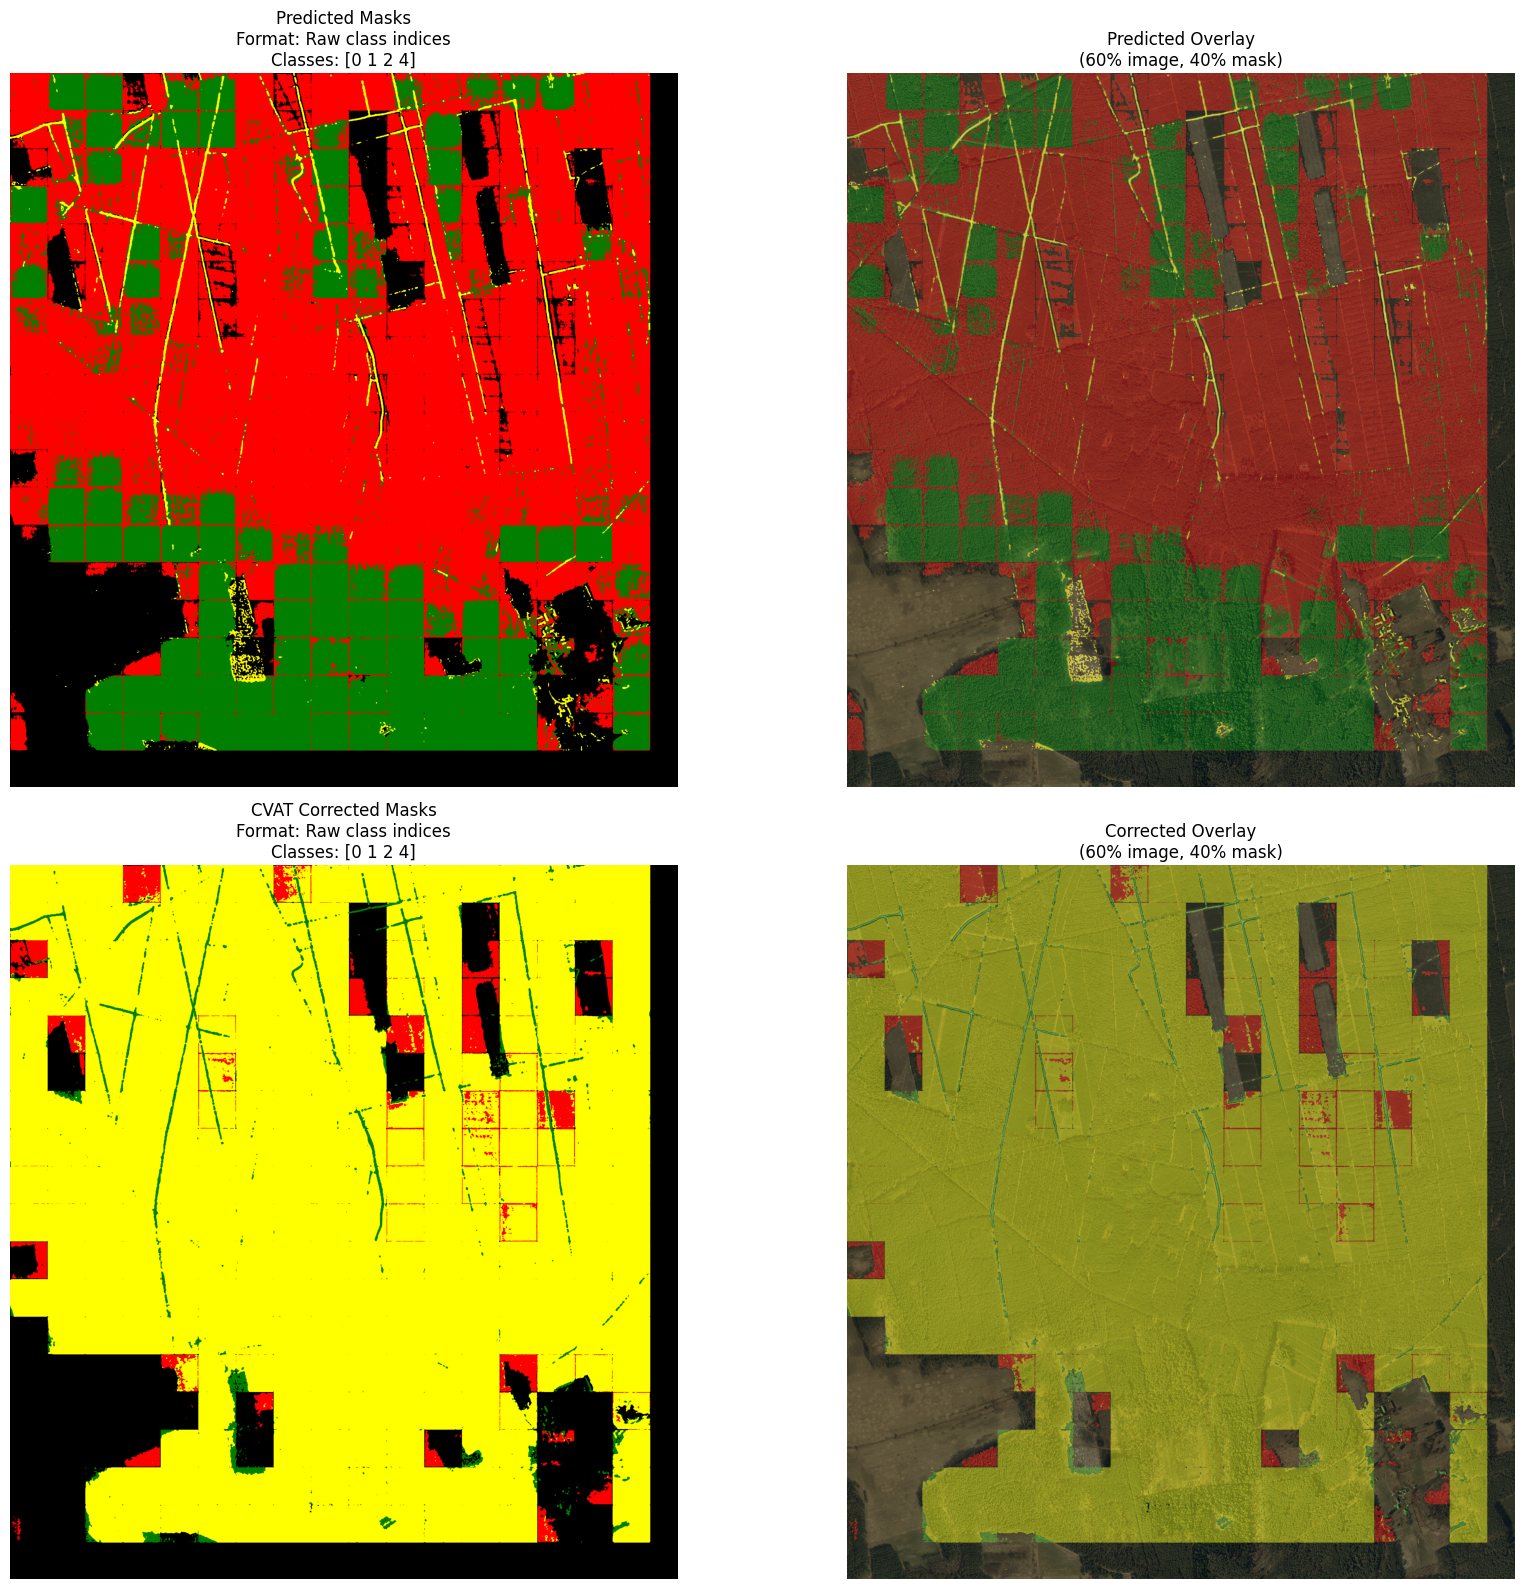


✓ Visualization saved: mal_workspace/predictions_vs_corrected.png


In [212]:
# Create visualization
if has_corrected:
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    
    # Row 0, Col 0: Predicted masks
    axes[0, 0].imshow(pred_rgb)
    axes[0, 0].set_title(f'Predicted Masks\nFormat: {"Palette-encoded" if pred_is_palette else "Raw class indices"}\nClasses: {pred_classes}', fontsize=12)
    axes[0, 0].axis('off')
    
    # Row 1, Col 0: Corrected masks
    axes[1, 0].imshow(corrected_rgb)
    axes[1, 0].set_title(f'CVAT Corrected Masks\nFormat: {"Palette-encoded" if corrected_is_palette else "Raw class indices"}\nClasses: {corrected_classes}', fontsize=12)
    axes[1, 0].axis('off')
    
    # Row 0, Col 1: Predicted with image overlay
    original = np.array(Image.open("cvat_test/images/M-33-7-A-d-2-3.tif")).astype(np.float32) / 255.0
    pred_overlay = 0.6 * original + 0.4 * pred_rgb
    axes[0, 1].imshow(np.clip(pred_overlay, 0, 1))
    axes[0, 1].set_title('Predicted Overlay\n(60% image, 40% mask)', fontsize=12)
    axes[0, 1].axis('off')
    
    # Row 1, Col 1: Corrected with image overlay
    corrected_overlay = 0.6 * original + 0.4 * corrected_rgb
    axes[1, 1].imshow(np.clip(corrected_overlay, 0, 1))
    axes[1, 1].set_title('Corrected Overlay\n(60% image, 40% mask)', fontsize=12)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig("mal_workspace/predictions_vs_corrected.png", dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Visualization saved: mal_workspace/predictions_vs_corrected.png")
else:
    # Show just the predicted masks
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    axes[0].imshow(pred_rgb)
    axes[0].set_title(f'Predicted Masks\nFormat: {"Palette-encoded" if pred_is_palette else "Raw class indices"}\nClasses: {pred_classes}', fontsize=12)
    axes[0].axis('off')
    
    original = np.array(Image.open("cvat_test/images/M-33-7-A-d-2-3.tif")).astype(np.float32) / 255.0
    pred_overlay = 0.6 * original + 0.4 * pred_rgb
    axes[1].imshow(np.clip(pred_overlay, 0, 1))
    axes[1].set_title('Predicted Overlay\n(60% image, 40% mask)', fontsize=12)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()